In [1]:
import pandas as pd
import numpy as np
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import plotly.express as px
from ipywidgets import interact
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score,roc_curve, auc
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
import ipywidgets as widgets
from sklearn.metrics import roc_auc_score

### Loading Dataset

In [2]:
# Load Data
crime_trends = pd.read_csv("CJA01.csv")
crime_hotspots_file = "CJA07.csv"

### identifying unique garda stations

In [3]:
crime_hotspots_df = pd.read_csv(crime_hotspots_file)

# Create a new DataFrame with unique Garda station names
unique_garda_stations_df = pd.DataFrame(crime_hotspots_df["Garda Station"].unique(), columns=["Garda Station"])

# Display first 5 rows using Pandas instead
print(unique_garda_stations_df.head())

                            Garda Station
0     35301 Abbeyfeale, Limerick Division
1  41201 Abbeyleix, Laois/Offaly Division
2          35302 Adare, Limerick Division
3        54101 Aglish, Waterford Division
4        23101 Ahascragh, Galway Division


### Adding lat and long according to their location (using Google Map API)

In [ ]:
import pandas as pd
import googlemaps
import time

# Replace with your Google Maps API key
API_KEY = " Your API Key"

# Initialize Google Maps client
gmaps = googlemaps.Client(key=API_KEY)

# Load crime hotspots dataset
crime_hotspots_df = pd.read_csv("CJA07.csv")

# Extract unique Garda stations
unique_garda_stations_df = pd.DataFrame(crime_hotspots_df["Garda Station"].unique(), columns=["Garda Station"])

# Save unique stations for reference
unique_garda_stations_df.to_csv("unique_garda_stations.csv", index=False)
print("Unique Garda stations saved as 'unique_garda_stations.csv'")

# Function to fetch latitude & longitude using Google Maps API
def get_coordinates_google(station_name):
    try:
        # Query the Google Maps Geocoding API
        location = gmaps.geocode(f"{station_name}, Ireland")

        if location:
            lat = location[0]["geometry"]["location"]["lat"]
            lon = location[0]["geometry"]["location"]["lng"]
            return lat, lon
        else:
            return None, None
    except Exception as e:
        print(f"Error fetching {station_name}: {e}")
        return None, None

# Apply function with a delay to prevent API blocking
unique_garda_stations_df["Latitude"], unique_garda_stations_df["Longitude"] = zip(
    *unique_garda_stations_df["Garda Station"].apply(lambda x: get_coordinates_google(x))
)

# Identify missing values
missing_coords_df = unique_garda_stations_df[unique_garda_stations_df["Latitude"].isnull()]
print("Stations with missing coordinates:")
print(missing_coords_df)

# Manually add missing coordinates
manual_coords = {
    "42201 Baile Atha Bui, Meath Division": (53.653042,-6.68423),  
    "33501 Béal atha an Ghaorthaidh, Cork West Division": (51.903614,-8.468399),
    "11101 Bailieboro, Cavan/Monaghan Division": (54.243563, -7.03949)
}

# Update both missing and incorrect coordinates in the DataFrame
for index, row in unique_garda_stations_df.iterrows():
    station_name = row["Garda Station"]
    if station_name in manual_coords:
        unique_garda_stations_df.loc[index, "Latitude"] = manual_coords[station_name][0]
        unique_garda_stations_df.loc[index, "Longitude"] = manual_coords[station_name][1]

# Save the updated DataFrame with coordinates
unique_garda_stations_df.to_csv("garda_stations_with_coordinates_google.csv", index=False)
print("Updated Garda station coordinates saved as 'garda_stations_with_coordinates_google.csv'.")

# Merge the coordinates back into the main crime dataset
crime_hotspots_df = crime_hotspots_df.merge(unique_garda_stations_df, on="Garda Station", how="left")

# Save the updated dataset
crime_hotspots_df.to_csv("crime_dataset.csv", index=False)
print("Updated crime dataset with coordinates saved as 'crime_dataset.csv'.")

# Display first few rows of the updated dataset
print(crime_hotspots_df.head())

# Display the final dataset with coordinates
print(unique_garda_stations_df.head())

# Verify if there are still any missing values
print("\nMissing values after manual corrections:")
print(unique_garda_stations_df.isnull().sum())


Unique Garda stations saved as 'unique_garda_stations.csv'
Error fetching 42201 Baile Atha Bui, Meath Division: HTTP Error: 400
Error fetching 33501 Béal atha an Ghaorthaidh, Cork West Division: HTTP Error: 400
Stations with missing coordinates:
                                         Garda Station  Latitude  Longitude
39               42201 Baile Atha Bui, Meath Division       NaN        NaN
100  33501 Béal atha an Ghaorthaidh, Cork West Div...       NaN        NaN
Updated Garda station coordinates saved as 'garda_stations_with_coordinates_google.csv'.
Updated crime dataset with coordinates saved as 'crime_dataset.csv'.
            STATISTIC Label  Year                        Garda Station  \
0  Recorded crime incidents  2003  35301 Abbeyfeale, Limerick Division   
1  Recorded crime incidents  2003  35301 Abbeyfeale, Limerick Division   
2  Recorded crime incidents  2003  35301 Abbeyfeale, Limerick Division   
3  Recorded crime incidents  2003  35301 Abbeyfeale, Limerick Division

In [5]:
hotspots = pd.read_csv("crime_dataset.csv")

### Dataset Overview

In [6]:
# Data Overview
print("=== Crime Trends Info ===")
print(crime_trends.info())
display(crime_trends.head())


=== Crime Trends Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1575 entries, 0 to 1574
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STATISTIC Label  1575 non-null   object 
 1   Year             1575 non-null   int64  
 2   Type of Offence  1575 non-null   object 
 3   UNIT             1575 non-null   object 
 4   VALUE            1574 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 61.7+ KB
None


,STATISTIC Label,Year,Type of Offence,UNIT,VALUE
0,Recorded crime incidents,2003,Homicide offences,Number,100.0
1,Recorded crime incidents,2003,Murder,Number,35.0
2,Recorded crime incidents,2003,Manslaughter,Number,16.0
3,Recorded crime incidents,2003,Infanticide,Number,0.0
4,Recorded crime incidents,2003,Dangerous driving leading to death,Number,49.0


In [7]:
print("\n=== Hotspots Info ===")
print(hotspots.info())
display(hotspots.head())



=== Hotspots Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142128 entries, 0 to 142127
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   STATISTIC Label  142128 non-null  object 
 1   Year             142128 non-null  int64  
 2   Garda Station    142128 non-null  object 
 3   Type of Offence  142128 non-null  object 
 4   UNIT             142128 non-null  object 
 5   VALUE            140710 non-null  float64
 6   Latitude         142128 non-null  float64
 7   Longitude        142128 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 8.7+ MB
None


,STATISTIC Label,Year,Garda Station,Type of Offence,UNIT,VALUE,Latitude,Longitude
0,Recorded crime incidents,2003,"35301 Abbeyfeale, Limerick Division","Attempts/threats to murder, assaults, harassme...",Number,18.0,52.385179,-9.300797
1,Recorded crime incidents,2003,"35301 Abbeyfeale, Limerick Division",Dangerous or negligent acts,Number,14.0,52.385179,-9.300797
2,Recorded crime incidents,2003,"35301 Abbeyfeale, Limerick Division",Kidnapping and related offences,Number,0.0,52.385179,-9.300797
3,Recorded crime incidents,2003,"35301 Abbeyfeale, Limerick Division","Robbery, extortion and hijacking offences",Number,0.0,52.385179,-9.300797
4,Recorded crime incidents,2003,"35301 Abbeyfeale, Limerick Division",Burglary and related offences,Number,27.0,52.385179,-9.300797


In [8]:
# Check for missing values
print("\nMissing values in Crime Trends:")
print(crime_trends.isna().sum())
print("\nMissing values in Hotspots:")
print(hotspots.isna().sum())


Missing values in Crime Trends:
STATISTIC Label    0
Year               0
Type of Offence    0
UNIT               0
VALUE              1
dtype: int64

Missing values in Hotspots:
STATISTIC Label       0
Year                  0
Garda Station         0
Type of Offence       0
UNIT                  0
VALUE              1418
Latitude              0
Longitude             0
dtype: int64


In [9]:
crime_trends = crime_trends.copy()
hotspots = hotspots.copy()


crime_trends['VALUE'] = crime_trends['VALUE'].fillna(0)
hotspots['VALUE'] = hotspots['VALUE'].fillna(0)


### Data preparation

In [10]:
# Convert Latitude/Longitude to Numeric
hotspots['Latitude'] = pd.to_numeric(hotspots['Latitude'], errors='coerce')
hotspots['Longitude'] = pd.to_numeric(hotspots['Longitude'], errors='coerce')

# Drop Rows with Missing Latitude/Longitude
hotspots = hotspots.dropna(subset=['Latitude', 'Longitude'])



In [11]:
# Aggregate duplicates if they exist
dup_count = hotspots.duplicated(['Garda Station', 'Year', 'Type of Offence', 'Latitude', 'Longitude']).sum()
if dup_count > 0:
    hotspots = hotspots.groupby([
        'STATISTIC Label', 'Year', 'Garda Station', 'Type of Offence',
        'UNIT', 'Latitude', 'Longitude'
    ], as_index=False)['VALUE'].sum()



In [12]:
# Station-year total crimes
station_year = hotspots.groupby(['Garda Station','Year','Latitude','Longitude'], as_index=False)['VALUE'].sum()
station_year.rename(columns={'VALUE': 'TotalCrimes'}, inplace=True)


In [13]:
offence_year_pivot = crime_trends.pivot_table(
    index='Year',
    columns='Type of Offence',
    values='VALUE',
    aggfunc='sum'
).fillna(0)


### EDA ( Exploratory Data Analysis)

In [14]:
# Ensure 'Type of Offence' column exists
crime_types = crime_trends['Type of Offence'].unique()
start_year, end_year = crime_trends['Year'].min(), crime_trends['Year'].max()

# Function to display trends interactively
def interactive_crime_trends(crime_type, start_year, end_year):
    filtered_data = crime_trends[
        (crime_trends['Type of Offence'] == crime_type) &
        (crime_trends['Year'].between(start_year, end_year))
    ]
    
    fig = px.line(filtered_data, x='Year', y='VALUE', 
                  title=f"{crime_type} Trends ({start_year}-{end_year})",
                  labels={"VALUE": "Crime Count", "Year": "Year"})
    
    display(fig)  

# Create Interactive Widgets
interact(
    interactive_crime_trends,
    crime_type=widgets.Dropdown(options=crime_types, description="Crime Type"),
    start_year=widgets.IntSlider(min=start_year, max=end_year, step=1, value=start_year, description="Start Year"),
    end_year=widgets.IntSlider(min=start_year, max=end_year, step=1, value=end_year, description="End Year")
);


interactive(children=(Dropdown(description='Crime Type', options=('Homicide offences', 'Murder', 'Manslaughter…

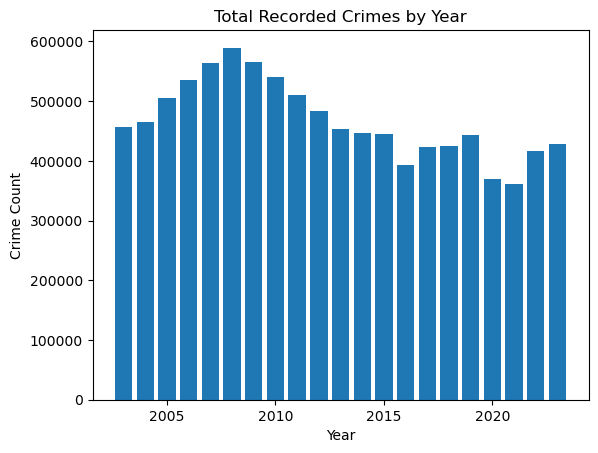

In [15]:
yearly_total = crime_trends.groupby('Year')['VALUE'].sum().reset_index()
plt.bar(yearly_total['Year'], yearly_total['VALUE'])
plt.title("Total Recorded Crimes by Year")
plt.xlabel("Year")
plt.ylabel("Crime Count")
plt.show()


### Modeling: HDBSCAN Clustering

In [16]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Apply log transformation to Crime Counts
station_year['LogCrimes'] = np.log1p(station_year['TotalCrimes'])


# HDBSCAN Clustering (Geo-Based)

# Convert Latitude/Longitude to radians for Haversine Clustering
station_year[['Latitude', 'Longitude']] = np.radians(station_year[['Latitude', 'Longitude']])

hdb_geo = hdbscan.HDBSCAN(
    # min_cluster_size=30,
    # min_samples=3,
    # alpha=2.0,
    min_cluster_size=10,
    min_samples=30,
    alpha=1.5,
    cluster_selection_method='leaf',
    metric='haversine'
)

labels_geo = hdb_geo.fit_predict(station_year[['Latitude', 'Longitude']])
station_year['Cluster_Geo'] = labels_geo

# Convert Latitude/Longitude back to degrees
station_year[['Latitude', 'Longitude']] = np.degrees(station_year[['Latitude', 'Longitude']])


# HDBSCAN Clustering (Crime-Based)

hdb_crime = hdbscan.HDBSCAN(
    min_cluster_size=10,
    min_samples=30,
    alpha=1.5,
    cluster_selection_method='leaf',
    metric='euclidean'
)

labels_crime = hdb_crime.fit_predict(station_year[['Latitude', 'Longitude', 'LogCrimes']])
station_year['Cluster_Crime'] = labels_crime


# Compute Silhouette Scores

valid_geo_clusters = station_year['Cluster_Geo'] != -1
if len(set(station_year.loc[valid_geo_clusters, 'Cluster_Geo'])) >= 2:
    sil_geo = silhouette_score(
        station_year.loc[valid_geo_clusters, ['Latitude', 'Longitude']],
        station_year.loc[valid_geo_clusters, 'Cluster_Geo']
    )
    print(f"Silhouette Score (Haversine - Geo-Based): {sil_geo:.3f}")

valid_crime_clusters = station_year['Cluster_Crime'] != -1
if len(set(station_year.loc[valid_crime_clusters, 'Cluster_Crime'])) >= 2:
    sil_crime = silhouette_score(
        station_year.loc[valid_crime_clusters, ['Latitude', 'Longitude', 'LogCrimes']],
        station_year.loc[valid_crime_clusters, 'Cluster_Crime']
    )
    print(f"Silhouette Score (Euclidean - Crime-Based): {sil_crime:.3f}")


Silhouette Score (Haversine - Geo-Based): 0.842
Silhouette Score (Euclidean - Crime-Based): 0.536


### Evaluation: Crime Hotspot Visualization

In [17]:
# Define Color Palette for Clusters
color_list = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige',
              'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink',
              'lightblue', 'lightgreen', 'gray', 'black', 'lightgray', 'brown']

# Extract available years for selection
years = station_year['Year'].unique()
years.sort()  # Sort years in ascending order

# Function to dynamically update map based on selected year
def generate_hotspot_map(selected_year):
    filtered_data = station_year[station_year['Year'] == selected_year]

    # Create Base Map Centered on Mean Crime Locations
    m = folium.Map(location=[filtered_data['Latitude'].mean(), filtered_data['Longitude'].mean()], zoom_start=7)

    # Map Both Clusters Together (Geo-Based & Crime-Based)
    for _, row in filtered_data.iterrows():
        cluster_geo = row['Cluster_Geo']
        cluster_crime = row['Cluster_Crime']

        # Determine color based on clustering type
        color_geo = "gray" if cluster_geo == -1 else color_list[int(cluster_geo) % len(color_list)]
        color_crime = "gray" if cluster_crime == -1 else color_list[int(cluster_crime) % len(color_list)]

        # Overlay Geo Clusters
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=5,
            popup=f"Geo Cluster: {cluster_geo}",
            color=color_geo,
            fill=True,
            fill_color=color_geo,
            fill_opacity=0.7
        ).add_to(m)

        # Overlay Crime-Intensity Clusters
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=5,
            popup=f"Crime Cluster: {cluster_crime}",
            color=color_crime,
            fill=True,
            fill_color=color_crime,
            fill_opacity=0.5
        ).add_to(m)

    # Save the map for viewing
    map_filename = f"crime_hotspots_{selected_year}.html"
    m.save(map_filename)
    print(f"Interactive crime hotspot map saved as: {map_filename}")

    return m

# Interactive Year Selection
interact(generate_hotspot_map, selected_year=widgets.IntSlider(min=years.min(), max=years.max(), step=1, value=years.min(), description="Select Year"));


interactive(children=(IntSlider(value=2003, description='Select Year', max=2023, min=2003), Output()), _dom_cl…

### Classification Predicting High-Crime Hotspots

In [18]:
from imblearn.over_sampling import SMOTE

# Ensure clustering column exists
cluster_column = 'Cluster_Geo'
if cluster_column in station_year.columns:
    cluster_stats = station_year.groupby(cluster_column)['TotalCrimes'].mean().reset_index(name='AvgClusterCrime')
    global_avg = station_year['TotalCrimes'].mean()

    # Mark clusters with above-average crime as hotspots
    cluster_stats['HotspotCluster'] = (cluster_stats['AvgClusterCrime'] > global_avg).astype(int)

    # Ensure the column exists before merging
    if 'HotspotCluster' in cluster_stats.columns:
        station_year = station_year.merge(cluster_stats[[cluster_column, 'HotspotCluster']], on=cluster_column, how='left')

    # **Fix: Fill missing HotspotCluster values**
    station_year['HotspotCluster'] = station_year['HotspotCluster'].fillna(0).astype(int)

# **Check if 'HotspotCluster' now exists**
if 'HotspotCluster' not in station_year.columns:
    raise KeyError("'HotspotCluster' is still missing. Check cluster merging step!")

# Ensure 'Year' exists before classification
if 'Year' in station_year.columns:
    classification_data = station_year[['Latitude', 'Longitude', 'Year', 'HotspotCluster']].dropna()
else:
    classification_data = hotspots[['Latitude', 'Longitude', 'Year', 'HotspotCluster']].dropna()

X = classification_data[['Latitude', 'Longitude', 'Year']]
y = classification_data['HotspotCluster']

# Apply SMOTE to Balance High & Low Crime Classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [19]:
# Train Random Forest Model
rf = RandomForestClassifier(n_estimators=100, max_depth=25, class_weight="balanced", random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)
y_probs = rf.predict_proba(X_test)[:, 1]

# Evaluation Metrics
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))



=== Classification Report ===
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1524
           1       0.87      0.82      0.84      1418

    accuracy                           0.85      2942
   macro avg       0.86      0.85      0.85      2942
weighted avg       0.86      0.85      0.85      2942



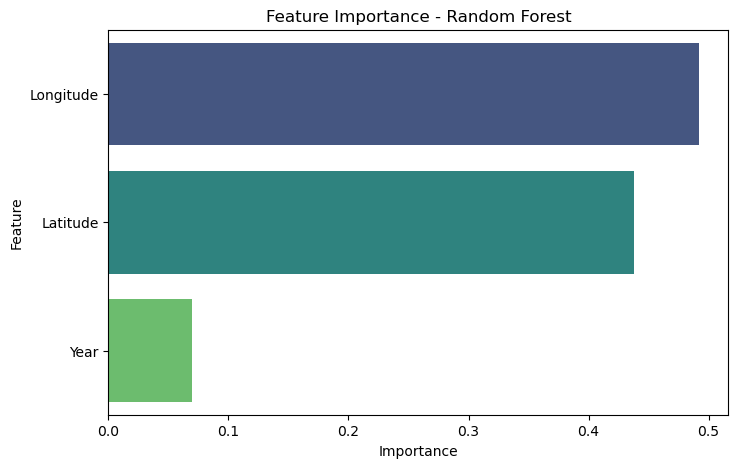

In [20]:
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
plt.title("Feature Importance - Random Forest")
plt.show()


### confusion matrix 

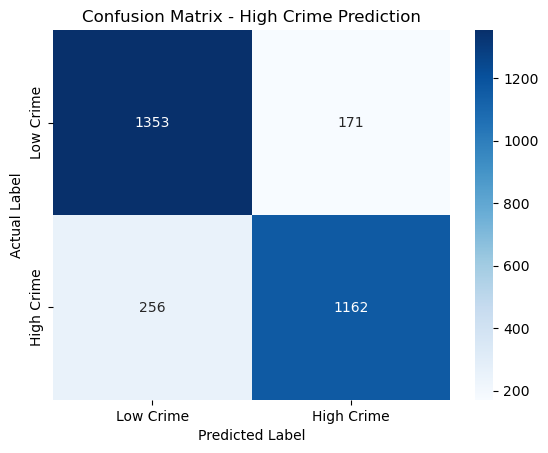

In [21]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Low Crime", "High Crime"], yticklabels=["Low Crime", "High Crime"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - High Crime Prediction")
plt.show()

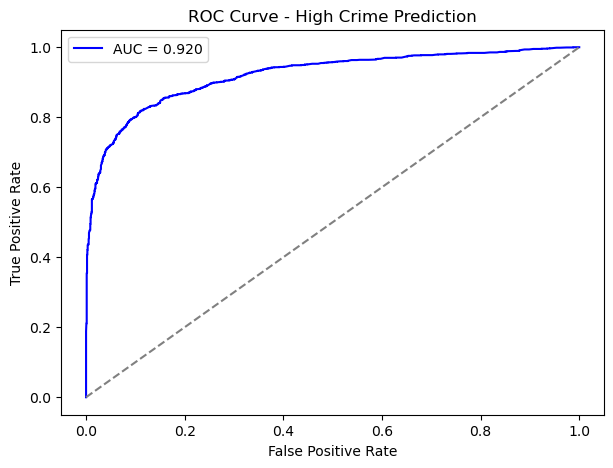

In [22]:

# ROC Curve & AUC Score
y_probs = rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - High Crime Prediction")
plt.legend()
plt.show()

In [23]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc')
print("Cross-validated AUC:", scores.mean())


Cross-validated AUC: 0.9240353414965317
